I was looking through some books and it struck me how strangely inconsistent many standard references are when it comes to adiabatic compressible pipe flow. There are standard methods for incompressible flow and isothermal compressible flow of an ideal gas, but when it comes to adiabatic pipe flow the guidance is very scattershot.

::: {.callout-note}
For brevity, from this point on whenever I refer to a flow I am referring to the *ideal gas* case in a constant area duct, unless otherwise specified
:::

As a brief review of some common references: Crane's[@crane-2013] gives a graphical method for adiabatic flow, which is the easiest to use with a pencil and paper, but doesn't give a lot of details on how that model was developed. Albright's[@albright-2009] recommends assuming flow is locally isentropic and gives a model of isentropic flow -- that is flow which is both adiabatic and reversible -- but with frictional losses also included, which allows for direct calculation if one assumes the friction factor is constant (with respect to the Reynold's number). Perry's[@tilton-2007] gives the adiabatic irreversible flow model (i.e. Fanno flow), though with only a sketch of how to perform the iterative solution. Hall[@hall-2018] gives the Fanno flow model and, helpfully, a procedure for how to actually do the calculations and example VBA code. Ludwig's[@coker-2007] gives both the isentropic and Fanno flow models but in a very confused manner: the section labeled "Adiabatic Flow" gives a model of isentropic flow (albeit with a typo in the equation) and suggests that *all adiabatic flow* is isentropic (which is false) and much later in a section labeled "Other Simplified Compressible Flow Methods" gives the Fanno flow model, though it doesn't explain what it is, misattributes the derivation, and gives no clues on how to use it. Probably the best reference to sort all of this out is Coulson and Richardson's[@chhabra-2018] as it provides easy to follow derivations of both the reversible and irreversible adiabatic flow models (the isentropic and Fanno flow models) and highlights their differences.

Another part of this confusion is differences in how the problem is being approached -- or what problem, exactly, one is trying to solve. Typically the isothermal and isentropic flow models are presented as ways to solve for the flowrate given the pressure drop between two points, whereas the Fanno flow model is often given in terms of the Mach number and one is solving for the pressure drop. If you have the Mach number, rather obviously, you already know the flow, and it is often left as an exercise for the reader to figure out how to use the Fanno flow model to *solve* for flow.

Given all of that, I thought it may be worthwhile to unpack these various approaches to adiabatic flow, and see how they perform relative to one another.

## Motivating Example

To give us something to work towards, suppose we wish calculate the flowrate of air in a horizontal section of piping -- a 20m length of 2in schedule 40 steel pipe. In this case the pipe starts a 100kPag vessel which is at ambient temperature and exits into the air at ambient pressure.

::: {#fig-system}
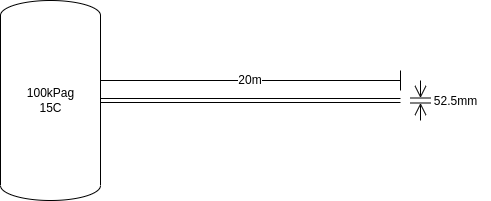

A sketch of the example system, a long straight section of pipe through which air is flowing.
:::

In [1]:
#| output: false
# Pipe dimensions
L = 20     # m
D = 0.0525 # m
ϵ = 0.0457*1e-3 # m

A = 0.25*π*D^2

0.0021647536878642167

For "ambient" conditions I am assuming *standard* conditions: 1 atmosphere and 15&deg;C

In [2]:
#| output: false
P₂ = 101325 #Pa
P₁ = P₂ + 100e3
T₁ = 288.15 #K

288.15

### Key Assumptions

+ Air is an ideal gas, Z=1
+ The ratio of heat capacities, &gamma; is constant
+ Heat loss is negligible, &Delta;q=0
+ Flow is steady state, $\dot{m}_{in} = \dot{m}_{out}$
+ Flow is turbulent, &alpha;=1
+ Flow is horizontal, &Delta;z=0
+ Friction factor is constant along the length

In [3]:
# Universal gas constant 
# to more digits than are at all necessary
R = 8.31446261815324 # Pa⋅m³/mol/K

# Some useful physical properties of air
Mw = 0.02896 # kg/mol
γ = 1.4      # Cp/Cv, ideal gas

# density of air, ideal gas law
ρ(P,T) = (P*Mw)/(R*T); # kg/m³

# viscosity of air, from Perry's
μ(T) = (1.425e-6*T^0.5039)/(1+108.3/T); # Pa⋅s

The mass velocity, *G* = *&rho;u*, in a pipe with constant cross-sectional area at steady state is constant[^reynolds], and the Reynold's number can be written in terms of *G* as:

$$ \mathrm{Re} = { {G D} \over \mu } $$

Where only the viscosity is a function of temperature, and for most gases only weakly so.

[^reynolds]: This is a consequence of the steady state assumption, $$\dot{m}_{in} = G_{in} A = G_{out} A = \dot{m}_{out}$$

In [4]:
# Reynold's number
Re(G,T) = G*D/μ(T);

The Darcy friction factor, *f*, is a function of the Reynolds number and, for ease of calculation, I am assuming the Churchill correlation applies[@tilton-2007 page 6-11], and that it can be taken as a constant at the average temperature (the arithmetic average of *T<sub>1</sub>* and *T<sub>2</sub>*)

In [5]:
function churchill(Re; κ=ϵ/D)
    A = (2.457 * log(1/((7/Re)^0.9 + 0.27*κ)))^16
    B = (37530/Re)^16
    return 8*((8/Re)^12 + 1/(A+B)^(3/2))^(1/12)
end;

K_entrance = 0.5
K_exit = 1.0

Kf(Re) = K_entrance + churchill(Re)*L/D + K_exit;

For a *large Reynolds number* approximation I am using the Nikuradse rough pipe law.[@crane-2013 page 1-10]

In [6]:
fₙ = (2*log10(3.7*D/ϵ))^-2

Kf() = K_entrance + fₙ*L/D + K_exit;

### Choking Flow

A pitfall of compressible flow calculations is that flow at the exit of the pipe cannot exceed *Ma*=1, once the exit velocity achieves sonic velocity then the exit pressure will rise and the overall flowrate will remain at a constant, no matter the upstream pressure.

The easiest way to check for this is to use the limiting factors in Crane's.[@crane-2013 A-23] Using the estimated *K<sub>f</sub>* &gt; 8 and *&gamma;*=1.4, we can check:

$$ {\Delta P \over P_1} \lt 0.762 $$

In [7]:
(P₁ - P₂)/P₁

0.496709300881659

In [8]:
(P₁ - P₂)/P₁ < 0.762

true

There is a fit to the critical pressure ratios, as a function of *K<sub>f</sub>*

$$\log \left( {\Delta P} \over P_1 \right) = A \left( \log K_f \right)^3 + B \left( \log K_f \right)^2 + C \left( \log K_f \right) + D$$

With the constants for *&gamma;*=1.4:

|   |         |
|--:|:--------|
| A | 0.0011  |
| B | -0.0302 |
| C | 0.238   |
| D | -0.6455 |

In [9]:
function critical_pressure(Kf)
    @assert Kf > 0
    x = log(Kf)
    y = 0.0011*x^3 - 0.0302*x^2 + 0.238*x - 0.6455
    return exp(y)
end

critical_pressure(Kf())

0.7707810480736812

In [10]:
(P₁ - P₂)/P₁ < critical_pressure(Kf())

true

For this problem we are well within the sub-sonic region.

## Mechanical Energy Balance

Consider the differential form of the mechanical energy balance:

$$ {u \over \alpha} du + g dz + v dP + \delta W_s + \delta F = 0 $$

From the assumptions listed above, and noting that in this system there is no shaft work *W<sub>s</sub>*, this can be simplified to:

$$ u du + v dP + {u^2 \over 2} {f \over D} dl = 0 $$

where *f* is the Darcy friction factor.

For compressible flow the velocity, *u*, varies along the length of the pipe while the mass velocity does not, so it is convenient to make the substitution *u*=*G/&rho;*=*Gv*

$$ G^2 v dv + v dP + G^2 {v^2 \over 2} {f \over D} dl = 0 $$

Dividing through by *v<sup>2</sup>* and integrating gives:

$$ G^2 \log \left( {v_2 \over v_1} \right) + \int_{P_1}^{P_2} {dP \over v} + {K_f \over 2} G^2 = 0 $$

where *K<sub>f</sub>* is the pipe friction *fL/D*

The integral $\int {dP \over v}$ is where the reversible and irreversible models differ, but they both amount to the same thing: integrate over an adiabatic path, and solve the mechanical energy balance for *G*.

## Reversible Adiabatic Flow (Isentropic Flow)

Typically the isentropic flow model comes as a consequence of examining non-isothermal flow more generally, where one assumes *Pv<sup>k</sup>* is constant with *k* being a function of heat transfer (for the isothermal case *k*=1). The adiabatic case is then taken to be when *k*=*&gamma;*. I think this is the greatest source of vaguery and confusion in the various sources I've looked at. Coulson and Richardson's[@chhabra-2018] emphasizes that this is only an approximation as this equates to assuming an isentropic path, but many other sources either don't make the distinction or only hint at it.

$$ Pv^\gamma = P_1 v_1^\gamma $$

$$ \int_{P_1}^{P_2} {dP \over v} = \int_{P_1}^{P_2} {1 \over v_1} \left( P \over P_1 \right)^{1 \over \gamma} dP \\
= {\gamma \over {\gamma + 1} } {P_1 \over v_1} \left( \left( P_2 \over P_1 \right)^{ {\gamma+1}\over\gamma} - 1 \right)$$

Substituting this into the mechanical energy balance gives

$$ G^2 \log \left( {v_2 \over v_1} \right) + {\gamma \over {\gamma + 1} } {P_1 \over v_1} \left( \left( P_2 \over P_1 \right)^{ {\gamma+1}\over\gamma} - 1 \right) + {K_f \over 2} G^2 = 0 $$

Making the substitution $$ {v_2 \over v_1} = \left( P_1 \over P_2 \right)^{1\over\gamma} $$

$$ \left( {K_f \over 2} - {1 \over \gamma} \log \left( {P_2 \over P_1} \right) \right) G^2 + {\gamma \over {\gamma + 1} } P_1 \rho_1 \left( \left( P_2 \over P_1 \right)^{ {\gamma+1}\over\gamma} - 1 \right) = 0 $$

This form is a convenient objective function for numerical solution, however it can be re-arranged to solve for *G*, giving:

$$ G = \sqrt{ { {2 \gamma \over {\gamma + 1} } P_1 \rho_1 \left( 1 - \left( P_2 \over P_1 \right)^{ {\gamma+1}\over\gamma} \right) } \over { K_f - {2 \over \gamma} \log \left( {P_2 \over P_1} \right) } } $$

Which is the form typically given in texts. If one assumes *K<sub>f</sub>* is a constant then the mass velocity can be calculated directly. In practice, however, *K<sub>f</sub>* is a function of the Reynolds number and so this must be solved numerically.

In [11]:
function isentropic_flow(P₁, K::Number; T₁=T₁, P₂=P₂, γ=γ)
    q = P₂/P₁
    ρ₁ = ρ(P₁,T₁)
    G = √( ((2γ/(γ+1))*P₁*ρ₁*(1-q^((γ+1)/γ)))/(K - (2/γ)*log(q)) )
    return G
end;

In [12]:
using Roots: find_zero

function isentropic_flow(P₁, K::Function; T₁=T₁, P₂=P₂, γ=γ) 
    # Initialize Parameters
    q = P₂/P₁
    ρ₁ = ρ(P₁,T₁)
    T₂ = T₁*(q^((γ-1)/γ))
    Tₐᵥ = (T₁+T₂)/2
    
    # Initial guess
    G_est = isentropic_flow(P₁, K(); T₁=T₁, P₂=P₂, γ=γ)
    
    # Numerically solve for G
    obj(G) = (K(Re(G,Tₐᵥ)) - (2/γ)*log(q))*(G^2) - (2γ/(γ+1))*P₁*ρ₁*(1-q^((γ+1)/γ))
    G = find_zero(obj, G_est)
    
    return G
end;

In [13]:
ṁ_i = isentropic_flow(P₁, Kf)*A

0.43138829795543004

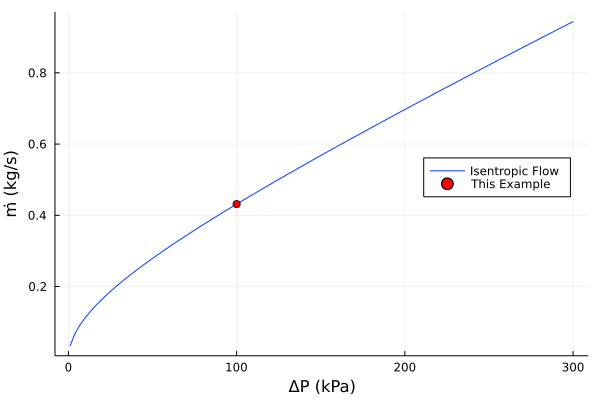

In [14]:
#| echo: false
#| label: fig-isentropic-flow
#| fig-cap: "The mass flowrate through the example piping system as a function of pressure drop, using an isentropic flow model."

using Plots: plot, plot!, palette

colors = palette(:seaborn_bright)

let
    Δps = range(1.0, 300.0, length = 100)
    ps = Δps.*1000 .+ P₂
    ṁ = isentropic_flow.(ps, Kf).*A
    plot(Δps, ṁ, lab="Isentropic Flow", xlabel="ΔP (kPa)", ylabel="ṁ (kg/s)", 
         legend=:right, color=colors[1])
    plot!([100], [ṁ_i], seriestype=:scatter, lab="This Example", color=:red)
end

## Irreversible Adiabatic Flow (Fanno Flow)

The integration for Fanno flow is decidedly more tedious. As a sketch, start with the invariant (which comes from taking an energy balance for an ideal gas):

$$ {1 \over 2} \left( Gv \right)^2 + {\gamma \over {\gamma -1} } Pv = \textrm{a constant}$$

Solve for *P*, take the derivative to determine *dP*, substitute and integrate. The result is:

$$ \int_{P_1}^{P_2} {dP \over v} = { {\gamma -1} \over {\gamma} } G^2 \left( \left(v_1 \over v_2\right) -1 -2 \log \left(v_1 \over v_2\right) \right) - \frac{1}{2} {P_1 \over v_1} \left( 1 - \left(v_1 \over v_2\right)^2 \right)$$

Which, when substituted into the mechanical energy balance and simplified, becomes:

$$ \left( K - { {\gamma -1} \over {2 \gamma} } \left( 1 - \left( { \rho_2 \over \rho_1 } \right)^2 \right) - { {\gamma +1} \over \gamma} \log \left( { \rho_2 \over \rho_1 } \right) \right) G^2 - \left( 1 - \left( { \rho_2 \over \rho_1 } \right)^2 \right) P_1 \rho_1 = 0 $$

and can be further re-arranged to solve for *G*

$$ G = \sqrt{ { P_1 \rho_1 \left( 1 - \left( { \rho_2 \over \rho_1 } \right)^2 \right) } \over { K - { {\gamma -1} \over {2 \gamma} } \left( 1 - \left( { \rho_2 \over \rho_1 } \right)^2 \right) - { {\gamma +1} \over \gamma} \log \left( { \rho_2 \over \rho_1 } \right) } } $$

The obvious complication here is that *&rho;<sub>2</sub>* is unknown, so solving this requires simultaneously solving for either *&rho;<sub>2</sub>* or *T<sub>2</sub>*.

Most often the Fanno flow model is given in terms of the Mach number, however the equation above is equivalent. This can be shown most easily by starting with the definition of the Fanno parameter, *Fa*, and the relation *K = Fa<sub>1</sub> - Fa<sub>2</sub>*, 

$$ Fa = \left(\frac{1 - Ma^2}{\gamma Ma^2}\right) + \left(\frac{\gamma + 1}{2\gamma}\right)\log\left[\frac{Ma^2}{\left(\frac{2}{\gamma + 1}\right)\left(1 + \frac{\gamma - 1}{2}Ma^2\right)}\right] $$

$$ K = \left(\frac{1 - Ma_1^2}{\gamma Ma_1^2}\right) - \left(\frac{1 - Ma_2^2}{\gamma Ma_2^2}\right) + \left(\frac{\gamma + 1}{2\gamma}\right)\log\left[\frac{Ma_1^2}{Ma_2^2}\frac{\left(1 + \frac{\gamma - 1}{2}Ma_2^2\right)}{\left(1 + \frac{\gamma - 1}{2}Ma_1^2\right)}\right] $$

Then, making the substitution:

$$\left(v_1 \over v_2\right)^2 = { {Ma_1^2 \left( 1 + { {\gamma-1}\over 2} Ma_2^2 \right)} \over {Ma_2^2 \left( 1 + { {\gamma-1}\over 2} Ma_1^2 \right)} }$$

we get:

$$ K = \left( \frac{1}{\gamma Ma_1^2} + \frac{\gamma-1}{2\gamma} \right) \left( 1 - \left(v_1 \over v_2\right)^2 \right) + \frac{\gamma + 1}{\gamma} \log\left(v_1 \over v_2\right) $$

Then, using the definition of the Mach number, in terms of *G*, $Ma=\frac{G}{\sqrt{\gamma P \rho} }$

$$ K = \left( \frac{P_1 \rho_1}{G^2} + \frac{\gamma-1}{2\gamma} \right) \left( 1 - \left(v_1 \over v_2\right)^2 \right) + \frac{\gamma + 1}{\gamma} \log\left(v_1 \over v_2\right) $$

Solving for *G*, and making the substitution *&rho; = 1/v*

$$ G = \sqrt{ { P_1 \rho_1 \left( 1 - \left( { \rho_2 \over \rho_1 } \right)^2 \right) } \over { K - { {\gamma -1} \over {2 \gamma} } \left( 1 - \left( { \rho_2 \over \rho_1 } \right)^2 \right) - { {\gamma +1} \over \gamma} \log \left( { \rho_2 \over \rho_1 } \right) } } $$

Which puts us back where we started.

When it comes to actually using the Fanno flow model, if the goal is to calculate the flowrate for a given pressure drop, working in terms of the specific volume or density is far easier than using the model given in terms of the Mach number.

### Approximating Temperature Change

An obvious simplifying assumption is to estimate the exit temperature using the relationship for isentropic flow.

$$ {T_2 \over T_1} = \left( P_2 \over P_1 \right)^{ {\gamma-1} \over \gamma} $$

If we were assuming *K<sub>f</sub>* is constant, then using this assumption to estimate the density at the exit allows for a direct calculation of the mass velocity, no numerical methods required. In the more general case, the flow still needs to be calculated iteratively as the friction factor is a function of the flow (Reynolds number).

In [15]:
function approx_fanno_flow(P₁, K::Number; T₁=T₁, P₂=P₂, γ=γ)
    ρ₁ = ρ(P₁, T₁)
    ρ₂ = ρ₁*(P₂/P₁)^(1/γ)
    q  = ρ₂/ρ₁
    G = √( (P₁*ρ₁*(1-q^2))/(K - ((γ-1)/(2γ))*(1-q^2) - ((γ+1)/γ)*log(q)) )
    return G
end;

In [16]:
using Roots: find_zero

function approx_fanno_flow(P₁, K::Function; T₁=T₁, P₂=P₂, γ=γ)
    # Initializing some parameters
    T₂ = T₁*(P₂/P₁)^((γ-1)/γ)
    ρ₁ = ρ(P₁, T₁)
    ρ₂ = ρ(P₂, T₂)
    q  = ρ₂/ρ₁
    Tₐᵥ  = (T₁+T₂)/2
    
    # Initial guess
    G_est = approx_fanno_flow(P₁, K(); T₁=T₁, P₂=P₂, γ=γ)
    
    # Numerically solve for G
    obj(G) = (K(Re(G,Tₐᵥ)) - ((γ-1)/(2γ))*(1-q^2) - ((γ+1)/γ)*log(q))*(G^2) - (1-q^2)*P₁*ρ₁
    G = find_zero(obj, G_est)
    
    return G
end;

In [17]:
ṁ_fa = approx_fanno_flow(P₁, Kf)*A

0.38355173684967075

### The Full Treatment

Actually calculating the exit conditions requires a little more work. I am going to simultaneously calculate the density at exit since it is somewhat simpler to work with than the temperature, though either could be done.

To start we note that:

$$ {1 \over 2} \left( Gv \right)^2 + {\gamma \over {\gamma -1} } Pv = C = \textrm{a constant}$$

Which is a quadratic in *v*, and solving for *v*:

$$ v = {1 \over G^2} \left( \sqrt{ \left( {\gamma \over {\gamma -1} } P \right)^2 + 2 G^2 C} - {\gamma \over {\gamma-1} } P \right) $$

Where *C* is calculated at the entrance conditions and *&rho;* = *1/v*.

From this the temperature at the exit can be backed out using the ideal gas law, and used to update the Reynolds number.

This makes the whole calculation somewhat more complicated, and I think that added complication makes the simplification that *K<sub>f</sub>* is constant pointless -- that assumption does not make *the math* easier in any case.

In [18]:
using Roots: find_zero

function fanno_flow(P₁, K::Function; T₁=T₁, P₂=P₂, γ=γ)
    # Initialize some parameters
    ρ₁ = ρ(P₁,T₁)
    
    # Initial guesses
    q = (P₂/P₁)^(1/γ) # isentropic
    G_est = √( (P₁*ρ₁*(1-q^2))/(K() - ((γ-1)/(2γ))*(1-q^2) - ((γ+1)/γ)*log(q)) )
    
    function obj(G)
        # Calculate the downstream density
        C  = 0.5*(G/ρ₁)^2 + (γ/(γ-1))*(P₁/ρ₁)
        G²v = √(((γ/(γ-1))*P₂)^2 + 2*(G^2)*C) - (γ/(γ-1))*P₂
        ρ₂ = (G^2)/G²v
        @assert ρ₂ > 0

        # Update Temperature dependent parameters
        T₂ = (P₂*Mw)/(R*ρ₂)
        Tₐᵥ = (T₁+T₂)/2

        # Calculate the objective value
        q  = ρ₂/ρ₁
        return (K(Re(G,Tₐᵥ)) - ((γ-1)/(2γ))*(1-q^2) - ((γ+1)/γ)*log(q))*G^2 - P₁*ρ₁*(1-q^2)
    end
    
    G = find_zero(obj, G_est)
    
    return G
end;

In [19]:
function fanno_flow(P₁, K::Number; T₁=T₁, P₂=P₂, γ=γ)
    fn() = K
    fn(Re) = K
    return fanno_flow(P₁, fn; T₁=T₁, P₂=P₂, γ=γ)
end;

In [20]:
ṁ_f = fanno_flow(P₁, Kf)*A

0.40934309494917254

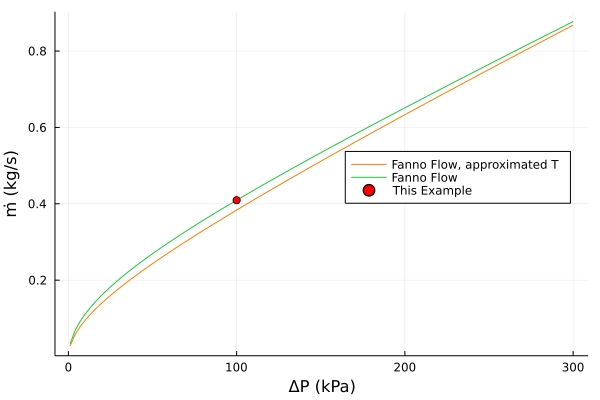

In [21]:
#| echo: false
#| label: fig-fanno
#| fig-cap: "The mass flowrate through the example piping system as a function of pressure drop, using an adiabatic Fanno flow model."

using Plots: plot, plot!

let
    Δps = range(1.0, 300.0, length = 100)
    ps = Δps.*1000 .+ P₂
    ṁ_constT = approx_fanno_flow.(ps, Kf).*A
    ṁ = fanno_flow.(ps, Kf).*A
    plot(Δps, ṁ_constT, lab="Fanno Flow, approximated T", color=colors[2])
    plot!(Δps, ṁ, lab="Fanno Flow", xlabel="ΔP (kPa)", ylabel="ṁ (kg/s)", 
         legend=:right, color=colors[3])
    plot!([100], [ṁ_f], seriestype=:scatter, lab="This Example", color=:red)
end

The approximation produces reasonable results in this case, especially at higher pressure drops, but one should always be cautious when mixing results from different models.[^models]

[^models]: This is something worth keeping mind more generally, as I have seen the assumption that Fanno flow is approximately isentropic (implicitly) taken for calculating different flow parameters, and it is often a bad assumption. For example, some references use the isentropic choking condition for a nozzle as an estimate for the choking condition in Fanno flow. Unless the pipe is incredibly short this is a terrible approximation -- in the current example the pressure drop exceeds the choking flow condition for a nozzle and yet the pipe flow is far from choked.</span>

## Expansion Factors (Y Factors)

*By far the simplest* method is to use a modified Darcy equation with expansion factors (Y factors). This takes the well known Darcy equation for incompressible pipe flow and, in a classic engineering move, tacks on a *Y* factor to account for all the complexity in adiabatic flow.

$$ G = Y \sqrt{ { 2 \rho_1 \Delta P } \over K } $$

Where the expansion factor, *Y*, is read off of a chart. This is great if you are working things out by hand, but can present some challenges when calculating things on a computer. Ludwig's[@coker-2007] provides a complicated series of equations to iteratively calculate the *Y* curves yourself, but I think if you are expending that level of effort then you really are not saving anything over using the Fanno model above. A much simpler approach is to either interpolate the critical expansion factor, *Y<sub>cr</sub>*, and critical pressure ratio, *q<sub>cr</sub>*, from the values given in Crane's or use a correlation for them (that's what I will use). Though this adds the wrinkle of only being able to use *Y* factors for gases with the same *&gamma;* as what is either tabulated or available in a correlation.


The actual *Y* value then comes from a simple linear relationship (where $q={ {\Delta P} \over P_1}$ )

$$ Y = \left( Y_{cr} -1 \right) \left( q \over q_{cr} \right) +1 $$

This has the added convenience of telling you when you have crossed into choked flow, it happens when *q*&gt;*q<sub>cr</sub>*.

One downside is that this method does not directly produce the exit conditions, so the Reynolds number is typically taken at the entrance conditions only. Since the Reynolds number is only a function of Temperature through the viscosity, this works out fine over ranges where the viscosity is approximately constant.[^temperature]

[^temperature]: The temperature can be worked out by using the method given in the section for Fanno flow, calculating the invariant at entrance conditions (once *G* is known) and then solving for the exit density.

In [22]:
# Correlations for γ=1.4

function Ycr(K)
    x = log(K)
    y = 0.0006*x^3 - 0.0185*x^2 + 0.1141*x - 0.5304
    return exp(y)
end;

function qcr(K)
    x = log(K)
    y = 0.0011*x^3 - 0.0302*x^2 + 0.238*x - 0.6455
    return exp(y)
end;

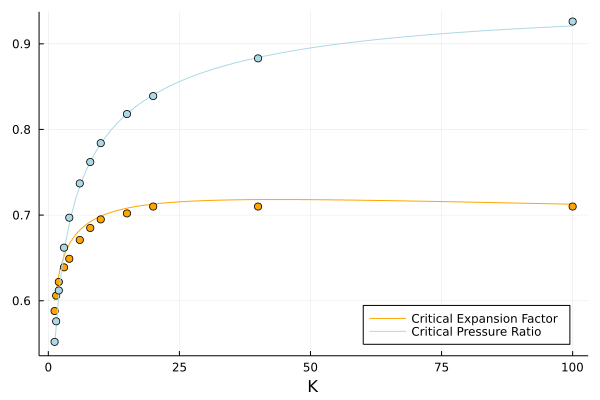

In [23]:
#| echo: false
#| label: fig-correl
#| fig-cap: "The correlation curves for critical expansion factor and critical pressure ratio, along with tabulated values from Crane's[@crane-2013 page A-23]."

using Plots: plot, plot!

K_crane = [1.200, 1.500, 2.000, 3.000, 4.000, 6.000, 8.000, 10.00, 15.00, 20.00, 40.00, 100.0]
Y_crane = [0.588, 0.606, 0.622, 0.639, 0.649, 0.671, 0.685, 0.695, 0.702, 0.710, 0.710, 0.710]
q_crane = [0.552, 0.576, 0.612, 0.662, 0.697, 0.737, 0.762, 0.784, 0.818, 0.839, 0.883, 0.926]

let
    
Ks = range(1.2, 100.0, length = 100)
Ys = Ycr.(Ks)
qs = qcr.(Ks)
plot(Ks, Ys, label="Critical Expansion Factor", xlabel="K", color=:orange, legend=:bottomright)
plot!(K_crane, Y_crane, seriestype=:scatter, color=:orange, label=false)
plot!(Ks, qs, label="Critical Pressure Ratio", color=:lightblue)
plot!(K_crane, q_crane, seriestype=:scatter, color=:lightblue, label=false)

end

The correlation curves I am using fit the tabulated values from Crane's reasonably well, but clearly the fit is not perfect.

In [24]:
function Y(K,q)
    Yc, qc = Ycr(K), qcr(K)
    if q < qc
        return (Yc-1)*(q/qc)+1
    else
        return Yc
    end
end;

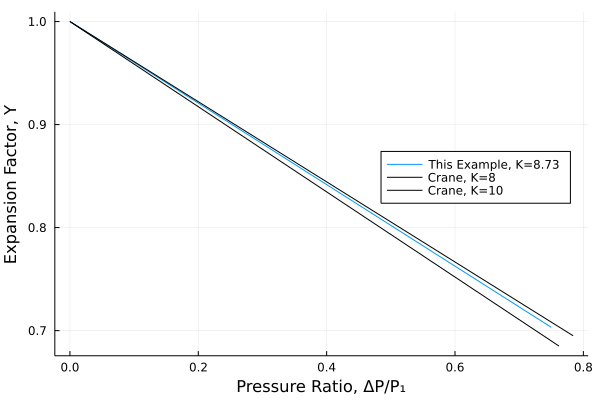

In [25]:
#| echo: false
#| label: fig-exp-factor
#| fig-cap: "The expansion factor vs pressure ratio, this calculated example falls between the reference curves from Crane's as expected[@crane-2013 page A-23]."

using Plots: plot, plot!

let
    qs = range(0, 0.75, length = 2)
    Ys = Y.(Kf(), qs)
    plot(qs, Ys, xlabel="Pressure Ratio, ΔP/P₁", ylabel="Expansion Factor, Y", label="This Example, K=$(round(Kf(); digits=2))", legend=:right)
    plot!([0, 0.762], [1, 0.685], label="Crane, K=8", color=:black)
    plot!([0, 0.784], [1, 0.695], label="Crane, K=10", color=:black)
end

The calculated curve is between the bracketing curves in Crane's and looks plausible.

If you are assuming that *K<sub>f</sub>* is constant then the mass velocity can be calculated directly, however if you wish to be more exact you can also iterate.

In [26]:
function modified_darcy(P₁, K::Number; T₁=T₁, P₂=P₂, γ=γ)
    ρ₁ = ρ(P₁,T₁)
    q = (P₁-P₂)/P₁
    G = Y(K,q)*√(2*ρ₁*(P₁-P₂)/K)
    return G
end;

In [27]:
using Roots: find_zero

function modified_darcy(P₁, K::Function; T₁=T₁, P₂=P₂, γ=γ)
    # Intialize Parameters
    ρ₁ = ρ(P₁,T₁)
    q = (P₁-P₂)/P₁
    
    # Initial Guess
    G_est = modified_darcy(P₁, K(); T₁=T₁, P₂=P₂, γ=γ)
    
    # Numerically solve for G
    obj(G) = G - modified_darcy(P₁, K(Re(G,T₁)); T₁=T₁, P₂=P₂, γ=γ) 
    G = find_zero(obj, G_est)
    
    return G
end;

In [28]:
ṁ_y = modified_darcy(P₁, Kf)*A

0.4049511071122898

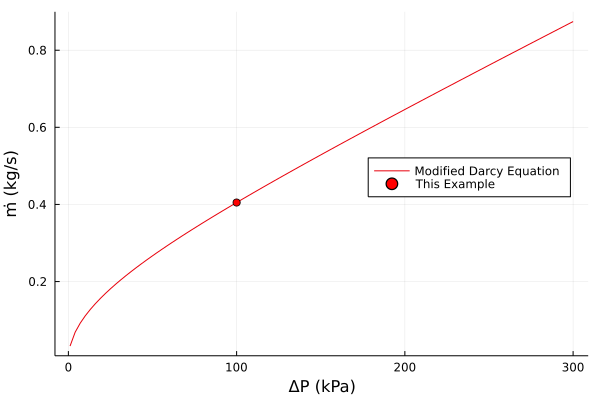

In [29]:
#| echo: false
#| label: fig-mod-darcy
#| fig-cap: "The mass flowrate through the example piping system as a function of pressure drop, using the modified Darcy equation."

using Plots: plot, plot!

let
    Δps = range(1.0, 300.0, length = 100)
    ps = Δps.*1000 .+ P₂
    ṁ = modified_darcy.(ps, Kf).*A
    plot(Δps, ṁ, lab="Modified Darcy Equation", xlabel="ΔP (kPa)", ylabel="ṁ (kg/s)", 
         legend=:right, color=colors[4])
    plot!([100], [ṁ_y], seriestype=:scatter, lab="This Example", color=:red)
end

## Comparison

Below is a plot showing all of the methods examined so far, including assuming the isothermal case (this a common recommendation for a simplifying assumption). The expansion factor method approximates the Fanno flow method, from which it was derived, quite well, to the point where they are essentially indistinguishable. The isothermal model is practically just as good for this particular example, while the isentropic model works well only for low pressure drops, the version of the Fanno flow that approximates the temperature as isentropic is the opposite, being the worst model at low pressure drops and converging towards the Fanno model at higher pressure drops.

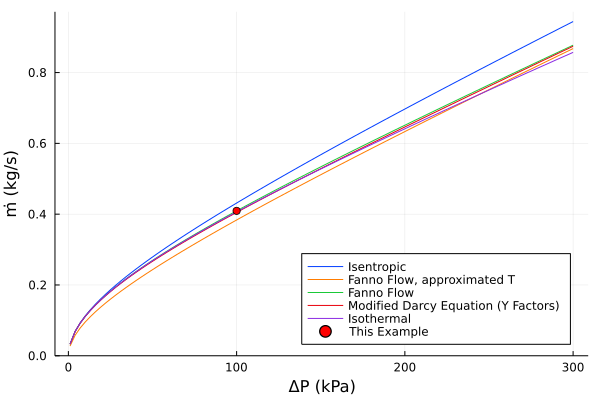

In [30]:
#| echo: false
#| label: fig-mass-flow
#| fig-cap: "The mass flowrate through the example piping system as a function of pressure drop, showing all of the discussed models. Note the significant overlap of the Fanno flow, modified Darcy equation, and isothermal flow curves."

using Plots: plot, plot!

function isothermal_flow(P₁, K::Number; T₁=T₁, P₂=P₂, γ=γ)
    ρ₁ = ρ(P₁,T₁)
    q = P₂/P₁
    G = √((ρ₁*P₁*(1-q^2))/(K-2*log(q)))
    return G
end

function isothermal_flow(P₁, K::Function; T₁=T₁, P₂=P₂, γ=γ)
    # Initialize Parameters
    ρ₁ = ρ(P₁,T₁)
    q = P₂/P₁
    
    # Initial Guesses
    G_est = isothermal_flow(P₁, K(); T₁=T₁, P₂=P₂, γ=γ)

    # Numerically solve for G
    obj(G) = (K(Re(G,T₁))- 2*log(q))*(G^2) - ρ₁*P₁*(1-q^2)
    G = find_zero(obj, G_est)
    
    return G
end

let
    
Δps = range(1.0, 300.0, length = 100)
ps = Δps.*1000 .+ P₂
ient = isentropic_flow.(ps, Kf).*A
fanno = fanno_flow.(ps, Kf).*A
approx_fanno = approx_fanno_flow.(ps, Kf).*A
itherm = isothermal_flow.(ps, Kf).*A
yfact = modified_darcy.(ps, Kf).*A

plot(Δps, ient, lab="Isentropic", xlabel="ΔP (kPa)", ylabel="ṁ (kg/s)", 
     legend=:bottomright, color=colors[1])
plot!(Δps, approx_fanno, lab="Fanno Flow, approximated T", color=colors[2])
plot!(Δps, fanno, lab="Fanno Flow", color=colors[3])
plot!(Δps, yfact, lab="Modified Darcy Equation (Y Factors)", color=colors[4])
plot!(Δps, itherm, lab="Isothermal", color=colors[5])
plot!([100], [ṁ_f], lab="This Example", seriestype=:scatter, color=:red)

end

But this is just one example, perhaps we can look at a wider range of *K<sub>f</sub>* and pressure drops. Conveniently, Crane's has a table with *K<sub>f</sub>* ranging from 1 to 100 and calculated pressure drops and expansion factors: the limiting factors. Using the models examined above, the effective expansion factors can be calculated quite easily for each K in Crane's table (taking the pressure ratios as givens).

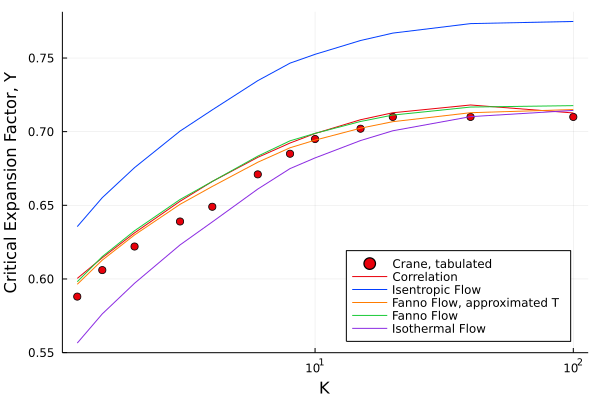

In [31]:
#| echo: false
#| label: fig-exp-and-models
#| fig-cap: "Calculated expansion factors for flow at the critical <em>K</em> values tabulated in Crane's, this represents flow at the critical pressure ratio[@crane-2013 page A-23]"
let

function Y_approxfan(K, r)
    P₁ = P₂/(1-r)
    ρ₁ = ρ(P₁,T₁)
    G = approx_fanno_flow(P₁, K)
    return G/√(2*ρ₁*(P₁-P₂)/K)
end;
    
function Y_fanno(K, r)
    P₁ = P₂/(1-r)
    ρ₁ = ρ(P₁,T₁)
    G = fanno_flow(P₁, K)
    return G/√(2*ρ₁*(P₁-P₂)/K)
end;

Yfa = [ Y_approxfan(K_crane[i], q_crane[i]) for i in range(1,length(K_crane)) ]
Yf  = [ Y_fanno(K_crane[i], q_crane[i]) for i in range(1,length(K_crane)) ]

Y_isotherm(K,q) = √(0.5*K*(1+q)/(K-2*log(q)))
Yt = [ Y_isotherm(K_crane[i], 1-q_crane[i]) for i in range(1,length(K_crane)) ]

Y_isentrop(K,q) = √(K*(γ/(γ+1))*(1-q^((γ+1)/γ))/((1-q)*(K-(2/γ)*log(q))))
Ye = [ Y_isentrop(K_crane[i], 1-q_crane[i]) for i in range(1,length(K_crane)) ]

plot(K_crane, Y_crane, seriestype=:scatter, color=colors[4],
     label="Crane, tabulated", ylabel="Critical Expansion Factor, Y", 
     xlabel="K", xaxis=:log, legend=:bottomright)
plot!(K_crane, Ycr.(K_crane), label="Correlation", color=colors[4])
plot!(K_crane, Ye, label="Isentropic Flow", color=colors[1])
plot!(K_crane, Yfa, label="Fanno Flow, approximated T", color=colors[2])
plot!(K_crane, Yf, label="Fanno Flow", color=colors[3])
plot!(K_crane, Yt, label="Isothermal Flow", color=colors[5])

end

Note that this represents the greatest pressure drop for a given *K<sub>f</sub>*, which should correspond to the "worst case" for most models (except the approximated Fanno model). The Fanno model and the correlation I was using to generate Y factors line up quite nicely, though there is a fair amount of scatter with the tabulated Y factors which is interesting. The isentropic model is close, but not in great agreement, over the entire range. What I find more interesting is how rapidly the isothermal model comes into agreement. We would expect, then, at *K<sub>f</sub>*=100 that the isothermal model would basically fall on top of the Fanno model over the entire range of pressure.

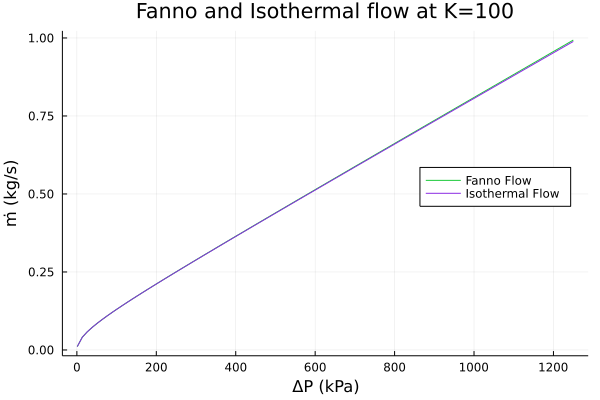

In [32]:
#| echo: false
#| label: fig-isotherm-fanno
#| fig-cap: "The mass flowrate for isothermal and Fanno flow models vs pressure drop for high K piping systems. Note that both lines overlap almost entirely for the entire range."

let
    
Δps = range(1, 1250, length = 100)
ps = Δps.*1000 .+ P₂

plot(Δps, (fanno_flow.(ps, 100).*A), lab="Fanno Flow", xlabel="ΔP (kPa)", ylabel="ṁ (kg/s)", 
     legend=:right, color=colors[3], 
     title="Fanno and Isothermal flow at K=100")
plot!(Δps, (isothermal_flow.(ps, 100).*A), lab="Isothermal Flow", color=colors[5])
    
end

They are basically indistinguishable. However, this is not at all implying that the temperature in the Fanno flow model is remaining constant over these large pressure drops. As one would expect, the adiabatic flow moves further from isothermal as the pressure drop increases. The mass flows just happen to be the same.

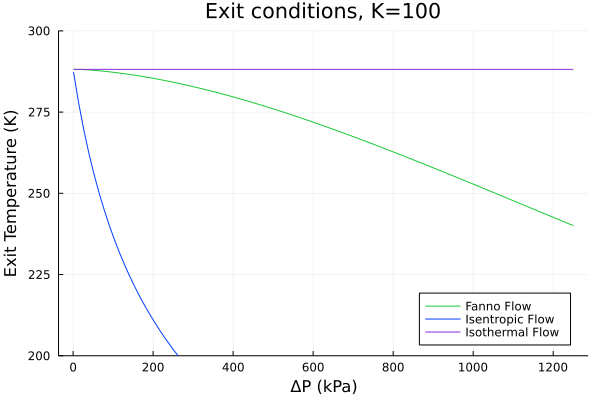

In [33]:
#| echo: false
#| label: fig-temp-drops
#| fig-cap: "The exit temperature for isothermal, isentropic, and Fanno flow models vs pressure drop for high K piping systems. Note that while the isothermal and Fanno flow models may give identical mass flowrates, the exit conditions are quite different."

let

function fanno_T(P₁, K)
    ρ₁ = ρ(P₁,T₁)
    G = fanno_flow(P₁, K)
    C  = 0.5*(G/ρ₁)^2 + (γ/(γ-1))*(P₁/ρ₁)
    G²v = √(((γ/(γ-1))*P₂)^2 + 2*(G^2)*C) - (γ/(γ-1))*P₂
    ρ₂ = (G^2)/G²v
    
    return (P₂*Mw)/(R*ρ₂)
end;
    
Δps = range(1, 1250, length = 100)
ps = Δps.*1000 .+ P₂

isentropic = [ T₁*(P₂/p)^((γ-1)/γ) for p in ps ]
    

plot(Δps, fanno_T.(ps, 100), lab="Fanno Flow", xlabel="ΔP (kPa)", ylabel="Exit Temperature (K)", 
     legend=:bottomright, color=colors[3], title="Exit conditions, K=100", ylim=(200,300))
plot!(Δps, isentropic, lab="Isentropic Flow", color=colors[1])
plot!([Δps[1], Δps[end]], [T₁, T₁], lab="Isothermal Flow", color=colors[5])

    
end

## Final Thoughts

I think the big take-away is that the isentropic flow model is not a very good approximation of Fanno flow and references that suggest that it is are in error. The other big take-away may be that, at least when calculating mass flow rates, the isothermal model is often better than one would expect: it does well at low pressure drops and also for long lines where *K<sub>f</sub>* is large. In practice, when the flow conditions are within the range of available *Y* factors, the modified Darcy equation is the easiest to use and gives excellent agreement with the full Fanno model, however when the situation is outside of that range and *Y* factors have to be calculated it is not a time-saver.

The big elephant in the room is that, in practice, no actual gas flow is perfectly ideal or perfectly adiabatic, nor is the friction factor truly a constant. These assumptions play a big role in the overall model error, and being fussy about some of the details of different adiabatic ideal gas models may amount to nothing in practice.


## References
::: {#refs}
:::
